In [1]:
# Import packages
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from scipy import stats
import time
import math
import cPickle as pickle

from looper import *

% matplotlib inline

In [2]:
import plotly
print plotly.__version__            # version 1.9.4 required
plotly.offline.init_notebook_mode() # run at the start of every notebook

import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns

1.12.6


In [3]:
# Define infection stage encoding function
def get_stage_for_time_pt(time_pt):
    time_pt = int(time_pt)
    if time_pt in [0,14,28,60]:
        stage = 'STAGE_BASE'
    elif time_pt==3:
        stage = 'STAGE_EARLY'
    elif time_pt==7:
        stage = 'STAGE_MIDDLE'
    else:
        stage = 'STAGE_LATE'
    return stage

In [4]:
# Rescale genes compared to baseline timepoint (i.e. 0)
def rescale_genes_to_baseline_timepoint_per_patient(all_indiv, time_col='Time', patient_col='Patient'):
    all_patients = all_indiv[patient_col].unique()
    all_indiv_rescaled = pd.DataFrame(columns=all_indiv.columns)
    non_gene_columns = [time_col, patient_col]
    gene_columns = [col for col in all_indiv.columns if col not in non_gene_columns]
    
    for patient in all_patients:
        print '{} {}: '.format(patient_col, patient),
        patient_df = all_indiv.query("{}=={}".format(patient_col, patient))
        patient_df.sort(columns='{}'.format(time_col), inplace=True)
        patient_df.reset_index(drop=True, inplace=True)
        # Normalize patient to timepoint 0
        genes_df = patient_df.ix[:,gene_columns]
        divsr = genes_df.iloc[0,:]
        genes_df = genes_df - divsr
        patient_df_r = genes_df.copy(deep=True)
        patient_df_r[time_col] = patient_df[time_col]
        patient_df_r[patient_col] = patient_df[patient_col]
        all_indiv_rescaled = pd.concat([all_indiv_rescaled, patient_df_r], axis = 0, join = 'inner')
        print 'Done.'
        
    all_indiv_rescaled.reset_index(drop=True, inplace=True)
    return all_indiv_rescaled

In [5]:
# For each individual's biggest gene pair loops, measure and report accuracy
def predict_accuracy(training_data, test_data, cols):
    K = 3 # Used to control number of neighbors used

    df1 = test_data
    df2 = training_data

    distances = {}
    mode_time = {}
    pred_list = []

    for ii in df1.index:
        pt1 = df1.ix[ii,cols].values
        dist_list = []

        # Compute distances to all training data
        for jj in df2.index:
            pt2 = df2.ix[jj,cols].values
            dist = compute_distance(pt1, pt2)
            dist_list.append((jj, dist))

        distances[ii] = dist_list

        # Find the K nearest neighbors
        knn = list(zip(*sorted(dist_list, key = lambda row: row[1])[:K])[0])
        time_pts_for_knn = np.median(df2.ix[knn,'Time'].values)
        mode_time[ii] = time_pts_for_knn
        
    acc_count = 0
    time_acc_count = 0
    for ii in df1.index:
        time_actual = test_data.ix[ii,'Time']
        time_pred = mode_time[ii]
        pred_list.append(time_pred)
        stage_actual = get_stage_for_time_pt(time_actual)
        stage_pred = get_stage_for_time_pt(time_pred)
        if stage_actual==stage_pred:
            acc_count += 1
        if time_actual==time_pred:
            time_acc_count += 1
            
    
    if len(mode_time.keys())==0:
        print 'Not enough data points.'
        return 0,0,pred_list
    else:
        return float(acc_count)/len(mode_time.keys()), float(time_acc_count)/len(mode_time.keys()), pred_list

In [6]:
# Set up globals
input_csv = "./YF17D_gse13699_montreal.csv"
version = 2

In [7]:
# Read input dataset
montreal_df = pd.read_csv(input_csv, header=None)
montreal_df.columns = montreal_df.ix[0,:]
montreal_df.drop(0,axis=0, inplace=True)
# montreal_df.head()

In [8]:
# Transpose and massage input dataset
df_montreal = montreal_df.transpose()
df_montreal.reset_index(inplace=True)
df_montreal.columns = df_montreal.ix[0,:]
df_montreal.drop(0,axis=0,inplace=True)
# df_montreal.shape

In [9]:
df_montreal.head()

0 Time Patient SLC35E2 PDCD1LG2  RPS28 IPO13 SYT14 AFAP1 GGTLA4  CDT1  ...   \
1   14      15       7        7  13.57  7.19     7     7      7     7  ...    
2    3      16       7        7  13.64  7.23     7     7      7     7  ...    
3    7      16       7        7  13.83   7.4     7     7      7  7.38  ...    
4   10      16       7        7  13.36  7.27     7     7      7     7  ...    
5   14      13       7        7  13.61  7.21     7     7      7     7  ...    

0 SMCR7 NUP107 FTSJ2 MGC9712 TRPM3 SMAD7 PCYOX1L EEF1A1 ACTB GAPDH  
1  8.54   7.47     7       7     7  7.43     NaN    NaN  NaN   NaN  
2  8.28   7.26     7       7  7.06  7.48     NaN    NaN  NaN   NaN  
3  8.97   7.41     7       7     7  7.89     NaN    NaN  NaN   NaN  
4   8.4    7.5     7       7     7  7.31     NaN    NaN  NaN   NaN  
5  8.71   7.35     7       7  7.01  7.59     NaN    NaN  NaN   NaN  

[5 rows x 22183 columns]

In [10]:
# Remove columns that are all NaNs
df_montreal.dropna(how='all', axis=1, inplace=True)

In [11]:
# Drop timept 60 
df_montreal.drop(df_montreal.query("Time==60").index, inplace=True)

In [12]:
# Print number of time points for individuals
for ii in df_montreal.Patient.unique():
    x = len(df_montreal[df_montreal.Patient==ii].Time)
    print "time points in Patient {} is {}".format(ii,x)

time points in Patient 15.0 is 6
time points in Patient 16.0 is 6
time points in Patient 13.0 is 5
time points in Patient 14.0 is 6
time points in Patient 18.0 is 6
time points in Patient 19.0 is 5
time points in Patient 20.0 is 5
time points in Patient 17.0 is 4
time points in Patient 4.0 is 5
time points in Patient 7.0 is 5
time points in Patient 8.0 is 6
time points in Patient 9.0 is 5
time points in Patient 10.0 is 6
time points in Patient 11.0 is 6
time points in Patient 12.0 is 6
time points in Patient 5.0 is 2


In [13]:
# Impute the missing time points
all_patients = df_montreal.Patient.unique()
all_time_pts = df_montreal.Time.unique()

median_time_df = pd.DataFrame(columns = df_montreal.columns)
for time_pt in all_time_pts:
    slice_df = df_montreal[df_montreal.Time==time_pt].median()
    if len(median_time_df)==0:
        median_time_df = slice_df
    else:
        median_time_df = pd.concat([median_time_df, slice_df], axis = 1, join = 'inner')   
        
median_time_df = median_time_df.transpose()

In [14]:
xdf = df_montreal

for patient in all_patients:
    patient_data = df_montreal[df_montreal.Patient==patient]
    existing_pts = patient_data.Time.unique()
    missing_pts = list(set(all_time_pts) - set(existing_pts))
    for jj in missing_pts:
        imputed_row = median_time_df[median_time_df.Time==jj]
        imputed_row.Patient = patient
        xdf = pd.concat([xdf, imputed_row], axis = 0, join = 'inner')

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [15]:
INDIV_REFRESH = False

if INDIV_REFRESH==True:
    all_indiv = filter_to_unique_genes(xdf)
    all_indiv.to_csv('montreal_all_indiv.csv')
else:
    all_indiv = pd.read_csv('montreal_all_indiv.csv', index_col = 0)

In [16]:
# Rescale genes compared to baseline timepoint (i.e. 0)
all_patients = all_indiv.Patient.unique()
all_indiv_rescaled = pd.DataFrame(columns=all_indiv.columns)

for patient in all_patients:
    print 'Patient {}: '.format(patient),
    patient_df = all_indiv.query("Patient=={}".format(patient))
    patient_df.sort(columns='Time', inplace=True)
    patient_df.reset_index(drop=True, inplace=True)
    # Normalize patient to timepoint 0
    genes_df = patient_df.ix[:,2:]
    divsr = genes_df.iloc[0,:]
    genes_df = genes_df - divsr
    patient_df.ix[:,2:] = genes_df
    all_indiv_rescaled = pd.concat([all_indiv_rescaled, patient_df], axis = 0, join = 'inner')
    print 'Done.'
    

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:3118: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

Patient 15.0:  Done.
Patient 16.0:  Done.
Patient 13.0:  Done.
Patient 14.0:  Done.
Patient 18.0:  Done.
Patient 19.0:  Done.
Patient 20.0:  Done.
Patient 17.0:  Done.
Patient 4.0:  Done.
Patient 7.0:  Done.
Patient 8.0:  Done.
Patient 9.0:  Done.
Patient 10.0:  Done.
Patient 11.0:  Done.
Patient 12.0:  Done.
Patient 5.0:  Done.


In [17]:
# Encode the different infection stages as BASE, EARLY, MIDDLE, LATE
df_montreal['STAGE_BASE'] = 0
df_montreal['STAGE_EARLY'] = 0
df_montreal['STAGE_MIDDLE'] = 0
df_montreal['STAGE_LATE'] = 0

for idx in df_montreal.index:
    time_pt = df_montreal.ix[idx,'Time'].astype(int)
    df_montreal.ix[idx,get_stage_for_time_pt(time_pt)] = 1

In [18]:
# Split input into training and test datasets
selected_patient_list = [11, 12, 13, 14, 15, 16, 17, 18, 19]
training_data = all_indiv.query("Patient not in @selected_patient_list")
test_data = all_indiv.query("Patient in @selected_patient_list")
training_data.sort(['Time'], ascending=True,inplace=True)
training_data.reset_index(drop=True, inplace=True)
test_data.sort(['Time'],ascending=True,inplace=True)
test_data.reset_index(drop=True, inplace=True)
print "Training Data:", training_data.shape
print "Test Data:", test_data.shape

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



Training Data: (43, 18197)
Test Data: (54, 18197)


In [20]:
# SPLICE POINT: Looper added here

# def get_loop_candidates(df, pctile, prox):
#     large_ranged_genes = get_large_ranged_genes(df, prctile=pctile)
#     psgenes_dict = get_phase_shifted_genes(df[large_ranged_genes], PROXIMITY=prox)
#     gene_pairs = []
#     for gene1 in psgenes_dict.keys():
#         for gene2 in psgenes_dict[gene1]:
#             gene_pairs.append((gene1,gene2))
#     return gene_pairs

In [21]:
# For each individual in training data, compute biggest_gene_pairs
unique_patients_in_training = training_data.Patient.unique()
biggest_gene_pairs = {}

for patient in unique_patients_in_training:
    patient_df = training_data[training_data.Patient==patient].ix[:,2:]
    biggest_gene_pairs[patient] = get_loop_candidates(patient_df, pctile=1, prox=5)
    print 'Done for patient {}'.format(patient)

LMBRD1  C16ORF69  HES4  EDG1  C6ORF62  HERC6  TMCO3  HNRPH3  TMED2  ACTR3  C1QA  RSAD2  OAS1  APAF1  IFI27  MX1  PLEKHA1  DEK  CDC20  ELF1  FLI1  CTSZ  FOS  THRAP6  PIGY  OASL  ZFP36L1  IL7R  LGP2  PELI1  EIF1B  CD9  PAPD4  ACSL4  FKBP1A  ACSL1  TMEM14B  RPS17  HSPA8  IFI6  ETS1  CYB5R4  EPSTI1  WIPF1  LOC729416  STAT2  ECGF1  MT2A  MT1A  NAT8B  PI3  CCNG1  LY6E  IGJ  CMTM6  SDHD  TMEM43  IFIT1  PPP1CC  HNRPH1  SGK  AXUD1  RPS13  Selenoprotein 15  ACTG1  EIF2AK2  ALAS2  ARL6IP1  GOLPH3  CLEC4A  RPLP0  FCER1A  RGS2  ATP6V1A  ELOVL5  PRKCB1  TP53INP1  LGALS9  7-Mar  PARP12  NRBF2  USP10  NKTR  PNN  SUPT3H  BST2  IFI44L  TMEM123  ATXN3  MOV10  WARS  LDHB  TOR1AIP1  HERC5  LOC644972  DDX21  KRT1  CYP4F3  RB1CC1  PPP1CB  PCMTD1  PRDX3  SUMO2  PRKAR1A  CMPK  FPRL1  KIAA1012  QPCT  XAF1  SERPINA13  GP9  CLINT1  IFI35  OAS3  SAS10  RAD21  S100A12  ABCB5  GPR109A  FAM13C1  CXCL5  TMEM183A  LEPROTL1  PROX1  ATP4A  DMRTB1  EIF2AK4  C13ORF7  LOC440087  LILRB1  ENTPD7  CTSK  PSMA5  CYP17A1  POLR3GL

In [22]:
common_gene_pairs = set(biggest_gene_pairs[7.0])
for gene_pairs in biggest_gene_pairs.values():
    common_gene_pairs = common_gene_pairs.union(set(gene_pairs))
    
print common_gene_pairs

set([('OAS2', 'OR5D16'), ('FCER1A', 'ALS2CR2'), ('FLJ41423', 'RASGEF1B'), ('PTGDS', 'FCER1A'), ('PCTK2', 'SNRPG'), ('EIF2AK2', 'KLRF1'), ('FAM101B', 'RPL39'), ('AADACL2', 'JARID1D'), ('OR5C1', 'MGC14376'), ('OR5D16', 'SCAMP5'), ('MT2A', 'KLRF1'), ('STARD10', 'ARPP-19'), ('HES4', 'KLRF1'), ('ITPKA', 'GPR75'), ('FLJ35740', 'MGC14376'), ('CA4', 'RPS17'), ('LOC441294', 'SNRPG'), ('SAMD9L', 'KLRF1'), ('SERPINA13', 'GPNMB'), ('GPR75', 'PCGF3'), ('DRAP1', 'C14ORF112'), ('FLJ33706', 'SSTR2'), ('PABPN1', 'MOV10'), ('IFIT3', 'SLN'), ('HSDL2', 'TNNT1'), ('USP10', 'RBX1'), ('SERPING1', 'KLRF1'), ('IFIT3', 'SNRPG'), ('HLA-C', 'RPLP0'), ('COPS7A', 'CTSG'), ('C9ORF91', 'SNRPG'), ('LY6E', 'GNLY'), ('HIST1H4C', 'LILRB1'), ('NCF1', 'EIF2AK4'), ('LOC644972', 'ITGA2B'), ('RASGEF1B', 'SP110'), ('UPF3B', 'FCER1A'), ('SLC30A8', 'UQCRQ'), ('LAP3', 'FCER1A'), ('BST2', 'GNLY'), ('FLJ33706', 'ETV6'), ('ADM', 'C9ORF91'), ('IFIT1', 'VPREB3'), ('OTOF', 'OR52N5'), ('DLG3', 'MGC14376'), ('IKZF1', 'PPM1K'), ('OTOF', '

In [23]:
def compute_distance(pt1, pt2):
    # Assuming that these pts. are lists of 2 numbers each
    dist = np.sqrt((pt1[0] - pt2[0])**2  +  (pt1[1] - pt2[1])**2)
    if isinstance(dist, np.ndarray):
        dist = dist[0]
    return dist

In [24]:
# Loop through each individual, compute accuracy on test data using loops from individual
best_gene_pairs = set()

ctr = 0

for patient in training_data.Patient.unique():
    gene_pairs_for_patient = common_gene_pairs #biggest_gene_pairs[patient]
    all_preds = {}
    
    for pair in gene_pairs_for_patient:
        stage_acc, time_acc, pred_list = predict_accuracy(training_data, test_data, list(pair))
        if time_acc>0.6:
            print 'Patient {}, pair {}, accuracy measures: {:.2f}, {:.2f}'.format(patient, pair, stage_acc, time_acc)
            best_gene_pairs.add(pair)
            
    ctr += 1
    if ctr==2:
        break

best_gene_pairs = list(best_gene_pairs)

Patient 20.0, pair ('MX1', 'ATP4A'), accuracy measures: 0.74, 0.63
Patient 20.0, pair ('OR5C1', 'ATP4A'), accuracy measures: 0.70, 0.61
Patient 20.0, pair ('LY6E', 'AKR1C3'), accuracy measures: 0.81, 0.72
Patient 20.0, pair ('MT1A', 'CDC20'), accuracy measures: 0.76, 0.63
Patient 20.0, pair ('UPF3B', 'CDC20'), accuracy measures: 0.83, 0.70
Patient 20.0, pair ('LY6E', 'C14ORF112'), accuracy measures: 0.78, 0.63
Patient 20.0, pair ('IFIT1', 'IL11'), accuracy measures: 0.76, 0.61
Patient 20.0, pair ('HERC6', 'CDC20'), accuracy measures: 0.85, 0.72
Patient 20.0, pair ('IFI44L', 'LEPROTL1'), accuracy measures: 0.78, 0.63
Patient 20.0, pair ('UPF3B', 'KLRF1'), accuracy measures: 0.81, 0.63
Patient 20.0, pair ('RSAD2', 'ATP4A'), accuracy measures: 0.78, 0.69
Patient 20.0, pair ('IFI44L', 'HLA-DRB1'), accuracy measures: 0.81, 0.61
Patient 20.0, pair ('IFIT2', 'ATP4A'), accuracy measures: 0.67, 0.63
Patient 20.0, pair ('IFI6', 'CDC20'), accuracy measures: 0.76, 0.61
Patient 20.0, pair ('LY6E', 

KeyboardInterrupt: 

# Confusion Matrix with Montreal on Montreal

In [25]:
traces = []
oos_data = test_data
patient_col = 'Patient'

for patient in oos_data[patient_col].unique():
    test_data_filt = oos_data[oos_data[patient_col]==patient]
    _, _, pred_list = predict_accuracy(training_data, test_data_filt, ['CDC20','IFI44L'])
    xdata = [get_stage_for_time_pt(pt) for pt in test_data_filt['Time'].values]
    ydata = [get_stage_for_time_pt(pt) for pt in pred_list]
    print test_data_filt['Time'].values, pred_list
    traces.append(go.Scatter(x=xdata, y=ydata, mode='markers'))

plotly.offline.iplot(traces)

[  0.   3.   7.  10.  14.  28.] [0.0, 3.0, 7.0, 14.0, 14.0, 0.0]
[  0.   3.   7.  10.  14.  28.] [0.0, 3.0, 7.0, 10.0, 14.0, 0.0]
[  0.   3.   7.  10.  14.  28.] [10.0, 3.0, 7.0, 10.0, 14.0, 28.0]
[  0.   3.   7.  10.  14.  28.] [0.0, 3.0, 7.0, 10.0, 14.0, 0.0]
[  0.   3.   7.  10.  14.  28.] [14.0, 3.0, 7.0, 10.0, 14.0, 28.0]
[  0.   3.   7.  10.  14.  28.] [0.0, 3.0, 7.0, 3.0, 14.0, 28.0]
[  0.   3.   7.  10.  14.  28.] [28.0, 3.0, 7.0, 7.0, 14.0, 28.0]
[  0.   3.   7.  10.  14.  28.] [0.0, 3.0, 10.0, 7.0, 14.0, 7.0]
[  0.   3.   7.  10.  14.  28.] [28.0, 3.0, 7.0, 7.0, 14.0, 28.0]


/Users/PoonamRath/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



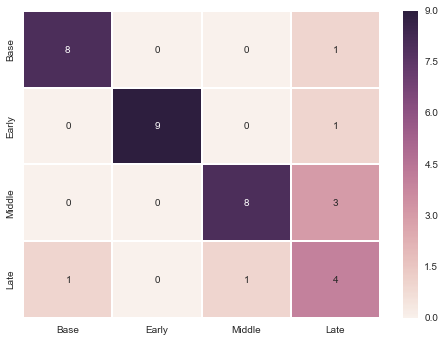

In [26]:
xdata = ['Base','Early','Middle','Late']
ydata = xdata
zdata = [[8,0,0,1],[0,9,0,1],[0,0,8,3],[1,0,1,4]]

df_hmap = pd.DataFrame(zdata)
df_hmap.columns = xdata
df_hmap.index = xdata
sns.heatmap(df_hmap, annot=True, fmt="d", linewidths=0.5)
plt.show()

# Leave-one-out Cross-validation on Montreal dataset

In [27]:
# Main x-val loop

time_acc_set = []
stage_acc_set = []

for patient in all_patients:
    # Separate out test patient and training data
    test_patient = all_indiv.query("Patient=={}".format(int(patient)))
    test_patient.sort(['Time'],ascending=True,inplace=True)
    test_patient.reset_index(drop=True, inplace=True)
    training_patients = all_indiv.query("Patient!={}".format(int(patient)))
    training_patients.sort(['Time'],ascending=True,inplace=True)
    training_patients.reset_index(drop=True, inplace=True)

    stage_acc, time_acc, pred_list = predict_accuracy(training_patients, test_patient, ['CDC20','IFI44L'])
    print "For patient {}, stage acc: {:.2f}, time acc: {:.2f}".format(patient, stage_acc, time_acc)
    time_acc_set.append(time_acc)
    stage_acc_set.append(stage_acc)

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)

/Users/PoonamRath/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



For patient 15.0, stage acc: 0.83, time acc: 0.83
For patient 16.0, stage acc: 0.50, time acc: 0.50
For patient 13.0, stage acc: 0.83, time acc: 0.67
For patient 14.0, stage acc: 0.83, time acc: 0.67
For patient 18.0, stage acc: 0.83, time acc: 0.67
For patient 19.0, stage acc: 0.83, time acc: 0.83
For patient 20.0, stage acc: 0.71, time acc: 0.57
For patient 17.0, stage acc: 0.83, time acc: 0.67
For patient 4.0, stage acc: 1.00, time acc: 1.00
For patient 7.0, stage acc: 1.00, time acc: 0.83
For patient 8.0, stage acc: 0.83, time acc: 0.67
For patient 9.0, stage acc: 1.00, time acc: 0.83
For patient 10.0, stage acc: 0.83, time acc: 0.83
For patient 11.0, stage acc: 0.67, time acc: 0.50
For patient 12.0, stage acc: 1.00, time acc: 0.83
For patient 5.0, stage acc: 0.83, time acc: 0.83


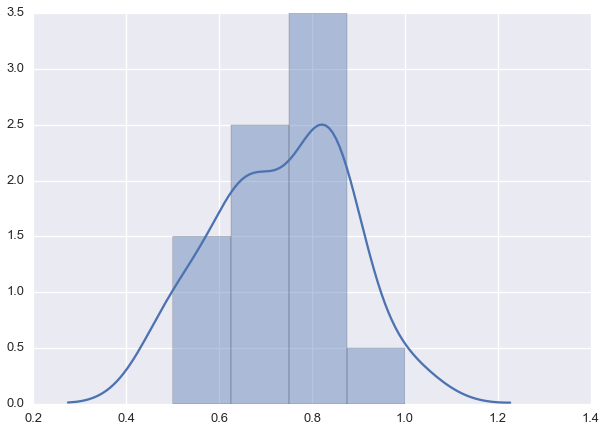

In [28]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.set_context("talk")
_, c2 = sns.color_palette("Set1", 2)
sns.distplot(np.array(time_acc_set))#, shade=True, c=c2)
plt.show()

## Out of sample testing on Lausanne dataset

In [34]:
# Read Lausanne dataset
df_lausanne = pd.read_csv('./lausanne_cleaned.csv', index_col = 0)
df_lausanne.reset_index(drop=True, inplace=True)
df_lausanne.head()

df_lausanne_cleaned = df_lausanne #filter_to_unique_genes(df_lausanne)
print df_lausanne_cleaned.shape, df_lausanne.shape

df_lausanne_rescaled = rescale_genes_to_baseline_timepoint_per_patient(df_lausanne_cleaned, patient_col='Patient_ID')

(33, 18198) (33, 18198)
Patient_ID 10:  Done.
Patient_ID 12:  Done.
Patient_ID 13:  Done.
Patient_ID 14:  Done.
Patient_ID 15:  Done.
Patient_ID 16:  Done.
Patient_ID 17:  Done.
Patient_ID 18:  Done.
Patient_ID 19:  Done.
Patient_ID 20:  Done.
Patient_ID 21:  Done.


/Users/PoonamRath/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



In [75]:
df_lausanne.shape

(33, 18198)

In [54]:
oos_data = df_lausanne
patient_col = 'Patient_ID'
all_preds_per_patient = {}

total_cases = oos_data.shape[0]

# Loop through each individual, compute accuracy on test data using loops from individual
for pair in best_gene_pairs: #response_wts.keys():
    acc_count = 0
    acc_list = []
    for patient in oos_data[patient_col].unique():
        test_data_filt = oos_data[oos_data[patient_col]==patient]
        all_preds = {}
        stage_acc, time_acc, pred_list = predict_accuracy(training_data, test_data_filt, list(pair))
        acc_list.append(stage_acc)
        acc_count += sum([get_stage_for_time_pt(pred)==get_stage_for_time_pt(test_data)
                          for pred, test_data in zip(pred_list, test_data_filt['Time'])])

    print 'Total accuracy for {}: {:.2f}'.format(pair, float(acc_count)/total_cases)

Total accuracy for ('EPSTI1', 'OR5D16'): 0.58
Total accuracy for ('IFI44L', 'IL11'): 0.76
Total accuracy for ('HERC5', 'CDC20'): 0.58
Total accuracy for ('LY6E', 'LEPROTL1'): 0.64
Total accuracy for ('IFIT2', 'ATP4A'): 0.52
Total accuracy for ('LY6E', 'LYPD2'): 0.67
Total accuracy for ('IFI44L', 'HLA-DRB1'): 0.58
Total accuracy for ('RSAD2', 'ATP4A'): 0.76
Total accuracy for ('STAT2', 'ATP4A'): 0.55
Total accuracy for ('IFI6', 'ATP4A'): 0.45
Total accuracy for ('UPF3B', 'KLRF1'): 0.33
Total accuracy for ('LY6E', 'AKR1C3'): 0.64
Total accuracy for ('IFI44L', 'CDC20'): 0.73
Total accuracy for ('XAF1', 'CDC20'): 0.70
Total accuracy for ('MX1', 'ATP4A'): 0.58
Total accuracy for ('IFI6', 'CDC20'): 0.36
Total accuracy for ('HERC6', 'KLRF1'): 0.76
Total accuracy for ('IFIT1', 'IL11'): 0.36
Total accuracy for ('LY6E', 'C14ORF112'): 0.58
Total accuracy for ('DMBX1', 'CDC20'): 0.33
Total accuracy for ('HERC5', 'IL11'): 0.64
Total accuracy for ('HERC6', 'CDC20'): 0.52
Total accuracy for ('LY6E', 

In [45]:
import plotly
print plotly.__version__            # version 1.9.4 required
plotly.offline.init_notebook_mode() # run at the start of every notebook

import plotly.plotly as py
import plotly.graph_objs as go


1.12.6


In [46]:
# Create a composite individual
df_composite, df_composite_scaled = create_composite_profile(training_data, 'Time', [], True, time_pt_zero = 0)

In [56]:
traces = []
time_axis = df_composite['Time'].values
traces.append(go.Scatter(x=time_axis, y=df_composite['IFI44L'], mode='lines+markers', name='IFI44L'))
traces.append(go.Scatter(x=time_axis, y=df_composite['CDC20'], mode='lines+markers', name='CDC20'))
plotly.offline.iplot(traces)

In [52]:
traces = []
oos_data = df_lausanne_cleaned #test_data
patient_col = 'Patient_ID'

for patient in oos_data[patient_col].unique():
    test_data_filt = oos_data[oos_data[patient_col]==patient]
    _, _, pred_list = predict_accuracy(training_data, test_data_filt, ['CDC20','IFI44L'])
    xdata = [get_stage_for_time_pt(pt) for pt in test_data_filt['Time'].values]
    ydata = [get_stage_for_time_pt(pt) for pt in pred_list]
    print test_data_filt['Time'].values, pred_list
    traces.append(go.Scatter(x=xdata, y=ydata, mode='markers'))

plotly.offline.iplot(traces)

[0 3 7] [3.0, 7.0, 7.0]
[0 3 7] [28.0, 7.0, 7.0]
[0 3 7] [0.0, 3.0, 7.0]
[0 3 7] [10.0, 7.0, 7.0]
[0 7 3] [28.0, 7.0, 3.0]
[0 3 7] [0.0, 3.0, 7.0]
[0 3 7] [28.0, 7.0, 7.0]
[0 3 7] [0.0, 7.0, 7.0]
[0 3 7] [28.0, 3.0, 7.0]
[0 7 3] [28.0, 28.0, 28.0]
[0 7 3] [28.0, 7.0, 3.0]


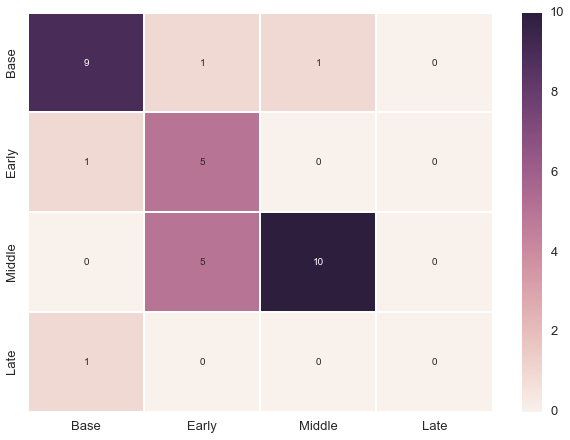

In [49]:
xdata = ['Base','Early','Middle','Late']
ydata = xdata
zdata = [[9,1,1,0],[1,5,0,0],[0,5,10,0],[1,0,0,0]]

df_hmap = pd.DataFrame(zdata)
df_hmap.columns = xdata
df_hmap.index = xdata
sns.heatmap(df_hmap, annot=True, fmt="d", linewidths=0.5)
plt.show()

## Lausanne: What about random gene pairs? What kind of accuracy will they generate?

In [73]:
# Randomized gene pair - baseline
random_gene_pairs = []
num_of_pairs = 50
filtered_cols = training_data.columns

for ii in range(0, num_of_pairs):
    idx_1 = int(np.random.rand()*len(filtered_cols)) #all_indiv.shape[1])
    idx_2 = int(np.random.rand()*len(filtered_cols)) #all_indiv.shape[1])
    random_gene_pairs.append((filtered_cols[idx_1], filtered_cols[idx_2]))
    
random_gene_pairs = [pair for pair in random_gene_pairs if pair not in best_gene_pairs]

In [74]:
time_acc_samples = []
for pair in random_gene_pairs:
    _, time_acc, pred_list = predict_accuracy(all_indiv, oos_data, list(pair))
    print 'For pair: {}, time accuracy: {}'.format(pair, time_acc)
    time_acc_samples.append(time_acc)

For pair: ('ODF2L', 'FLJ10986'), time accuracy: 0.333333333333
For pair: ('USP36', 'MYL6B'), time accuracy: 0.333333333333
For pair: ('ACO1', 'CALD1'), time accuracy: 0.333333333333
For pair: ('KRT6L', 'FAM35A'), time accuracy: 0.333333333333
For pair: ('TARSL2', 'RAD54L2'), time accuracy: 0.333333333333
For pair: ('DNAH5', 'FBXO44'), time accuracy: 0.333333333333
For pair: ('CCL27', 'PKMYT1'), time accuracy: 0.333333333333
For pair: ('PSG5', 'NOLC1'), time accuracy: 0.333333333333
For pair: ('TRIM8', 'IVNS1ABP'), time accuracy: 0.333333333333
For pair: ('C14ORF179', 'OR2F2'), time accuracy: 0.333333333333
For pair: ('SP5', 'HIST1H3E'), time accuracy: 0.333333333333
For pair: ('RPS6', 'RNF111'), time accuracy: 0.333333333333
For pair: ('TFDP3', 'GDAP1L1'), time accuracy: 0.333333333333
For pair: ('C4ORF19', 'FLJ20920'), time accuracy: 0.333333333333
For pair: ('TTC29', 'WDR41'), time accuracy: 0.333333333333
For pair: ('MUTED', 'KIAA1009'), time accuracy: 0.333333333333
For pair: ('NCO

In [76]:
picked_acc_samples = []
for pair in best_gene_pairs: #response_wts.keys():
    _, time_acc, pred_list = predict_accuracy(all_indiv, oos_data, list(pair))
    print '{}, {}, {:.2f}'.format(pair[0], pair[1], time_acc)
    picked_acc_samples.append(time_acc)

EPSTI1, OR5D16, 0.33
IFI44L, IL11, 0.33
HERC5, CDC20, 0.33
LY6E, LEPROTL1, 0.33
IFIT2, ATP4A, 0.33
LY6E, LYPD2, 0.33
IFI44L, HLA-DRB1, 0.33
RSAD2, ATP4A, 0.33
STAT2, ATP4A, 0.33
IFI6, ATP4A, 0.33
UPF3B, KLRF1, 0.00
LY6E, AKR1C3, 0.33
IFI44L, CDC20, 0.00
XAF1, CDC20, 0.00
MX1, ATP4A, 0.33
IFI6, CDC20, 0.33
HERC6, KLRF1, 0.00
IFIT1, IL11, 0.00
LY6E, C14ORF112, 0.33
DMBX1, CDC20, 0.33
HERC5, IL11, 0.33
HERC6, CDC20, 0.33
LY6E, KLRF1, 0.00
XAF1, ATP4A, 0.00
MT1A, CDC20, 0.33
MX1, CDC20, 0.33
UPF3B, CDC20, 0.33
IFI44L, ATP4A, 0.33
OR5C1, ATP4A, 0.33
OASL, CDC20, 0.33
IFI44L, LEPROTL1, 0.33
RSAD2, CDC20, 0.33


In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.set_context("talk")
# with plt.style.context("fivethirtyeight"):
# #     sns.distplot(picked_acc_samples, bins=20)
_, c2, c3 = sns.color_palette("Set1", 3)
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
# sns.despine()
sns.kdeplot(np.array(time_acc_samples), shade=True, c=c2)
sns.kdeplot(np.array(picked_acc_samples), shade=True, c=c3)
plt.show()

In [ ]:
from scipy.stats import ks_2samp
KSstat, KS_p_value = ks_2samp(time_acc_samples, picked_acc_samples)
print KSstat, KS_p_value

## Out of sample testing on Emory dataset

In [66]:
df_emory = pd.read_csv('./emory.csv', index_col=0)
df_emory.drop('Probeset', axis=1, inplace=True)
df_emory = df_emory.transpose()
df_emory.columns = df_emory.ix['Symbol',:]
df_emory.drop('Symbol', axis=0, inplace=True)
df_emory['Trial'] = 0
df_emory['Patient'] = 0
df_emory['Time'] = 0
for ii in df_emory.index:
    trial, patient, _, time = ii.split('_')
    df_emory.ix[ii, 'Trial'] = int(trial.split('T')[1])
    df_emory.ix[ii, 'Patient'], df_emory.ix[ii, 'Time'] = patient, time
df_emory.reset_index(drop=True, inplace=True)
df_emory = df_emory.ix[:,df_emory.columns.str.contains('nan')==False]
df_emory['Time'] = df_emory['Time'].astype(float)
allowed_time = [0,3,7,10]
df_emory = df_emory.query("Time in @allowed_time")

df_emory.head()

Symbol    CCDC124      STK35     DPYSL4        GJC2      FMNL1        LIG3  \
0               0          0          0           0          0           0   
1       0.0117348  -0.041622  -0.282361   -0.136304   0.654204   -0.282389   
2       0.0752805  0.0597387  -0.287022   0.0380007    0.89913 -0.00382153   
3               0          0          0           0          0           0   
4        0.440305   0.519636  0.0866475 -0.00211628 -0.0596556   0.0131877   

Symbol       CA6     BRPF1        SRL      BRMS1 ...       DRD4     GABRR1  \
0              0         0          0          0 ...          0          0   
1      -0.120975  0.343599  0.0832664 -0.0922283 ...   0.160766   0.105849   
2      -0.289142  0.851968 -0.0418181   0.118149 ...  -0.461325 -0.0250599   
3              0         0          0          0 ...          0          0   
4       0.256624  0.205918  -0.106978   -0.10926 ...  -0.169443   0.483395   

Symbol     KRT10        PIP     MS4A3 SECISBP2L     ZNF460 Trial Patient Time  
0              0          0         0         0          0     1    1901    0  
1      -0.302903  -0.188469  -1.09228  0.216505 -0.0395127     1    1901    3  
2      -0.631458  0.0694877  -1.45047  0.539546  -0.121665     1    1901    7  
3              0          0         0         0          0     1    1902    0  
4        0.42801  -0.130528 -0.962774  0.874053 -0.0362385     1    1902    3  

[5 rows x 10285 columns]

In [67]:
len(df_emory.Patient.unique())

25

In [68]:
df_montreal_lausanne = pd.concat([all_indiv_rescaled, df_lausanne_rescaled], axis = 0, join = 'inner')
df_montreal_lausanne.shape

(130, 18196)

In [72]:
oos_data = df_emory
patient_col = 'Patient'
total_cases = oos_data.shape[0]
all_pred_acts = []

# Loop through each individual, compute accuracy on test data using loops from individual
pair = ('CDC20', 'IFI44L')
acc_count = 0
for patient in oos_data[patient_col].unique():
    test_data_filt = oos_data[oos_data[patient_col]==patient]
    all_preds = {}
    stage_acc, time_acc, pred_list = predict_accuracy(df_montreal_lausanne, test_data_filt, list(pair))
    pred_act_pair = zip(pred_list, test_data_filt['Time'])
    acc_count += sum([get_stage_for_time_pt(pred)==get_stage_for_time_pt(test_data)
                      for pred, test_data in zip(pred_list, test_data_filt['Time'])])
    for jj in pred_act_pair:
        all_pred_acts.append((patient, jj[0], jj[1]))
        
print 'Total accuracy for {}: {:.2f}'.format(pair, float(acc_count)/total_cases)

Total accuracy for ('CDC20', 'IFI44L'): 0.65


In [77]:
df_emory.shape

(75, 10285)

In [78]:
traces = []
oos_data = df_emory 
patient_col = 'Patient'

for patient in oos_data[patient_col].unique():
    test_data_filt = oos_data[oos_data[patient_col]==patient]
    _, _, pred_list = predict_accuracy(all_indiv_rescaled, test_data_filt, ['CDC20','IFI44L'])
    xdata = [get_stage_for_time_pt(pt) for pt in test_data_filt['Time'].values]
    ydata = [get_stage_for_time_pt(pt) for pt in pred_list]
    print test_data_filt['Time'].values, pred_list
    traces.append(go.Scatter(x=xdata, y=ydata, mode='markers'))

plotly.offline.iplot(traces)

[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 0.0, 14.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 10.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 10.0, 10.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 0.0, 14.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 3.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]
[ 0.  3.  7.] [0.0, 10.0, 7.0]
[ 0.  3.  7.] [0.0, 7.0, 7.0]


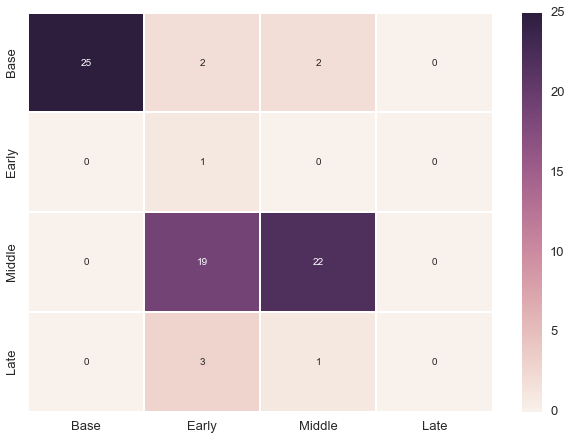

In [79]:
xdata = ['Base','Early','Middle','Late']
ydata = xdata
zdata = [[25,2,2,0],[0,1,0,0],[0,19,22,0],[0,3,1,0]]

df_hmap = pd.DataFrame(zdata)
df_hmap.columns = xdata
df_hmap.index = xdata
sns.heatmap(df_hmap, annot=True, fmt="d", linewidths=0.5)
plt.show()